Eric Lisboa Queiroz

Parte A: ANÁLISE DO SINAL DO MOTOR

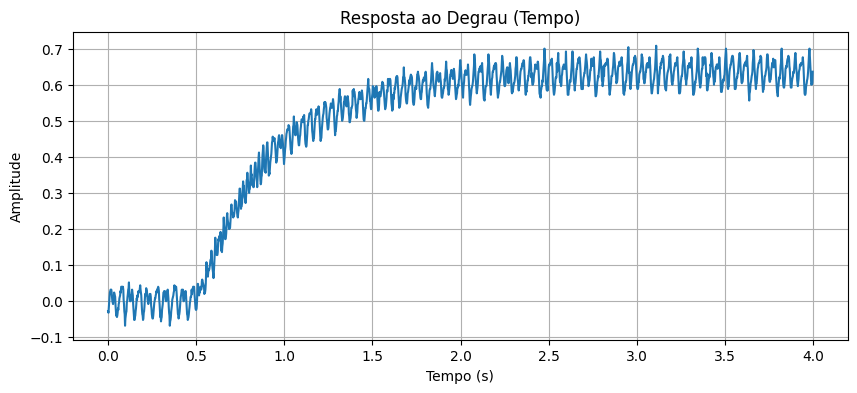

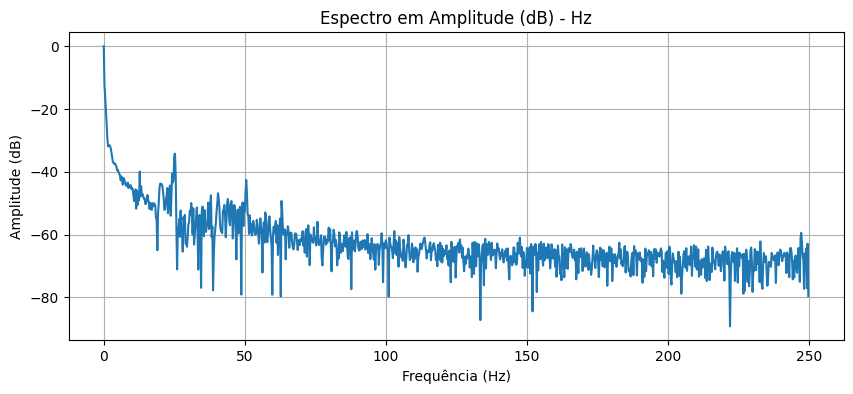

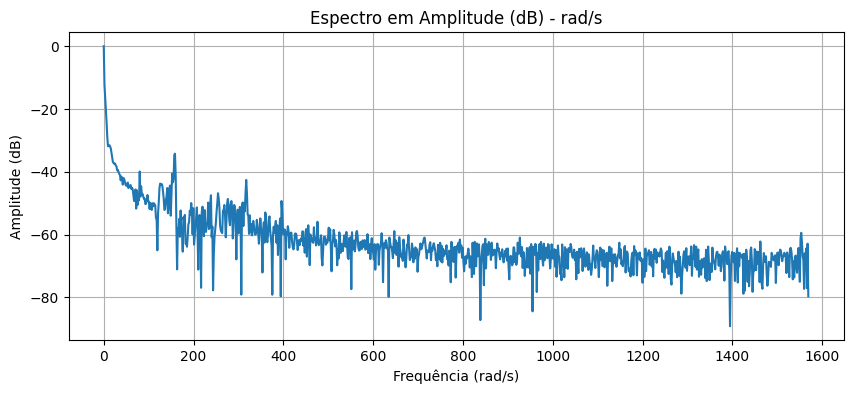

Análise concluída: tempo, espectro em Hz e espectro em rad/s.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.fft import fft, fftfreq

# ---------------------------------------------------------
# 1) Carregar o arquivo .mat
# ---------------------------------------------------------
dados = scipy.io.loadmat("motor.mat")
v = dados['v'].flatten()
fs = 500  # Hz

N = len(v)
t = np.arange(N) / fs

# ---------------------------------------------------------
# 2) Gráfico temporal da resposta ao degrau
# ---------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(t, v)
plt.title('Resposta ao Degrau (Tempo)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3) Espectro em Hz (sem janelamento)
# ---------------------------------------------------------
V = fft(v)
freqs = fftfreq(N, 1/fs)

# Apenas metade positiva
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
V_pos = np.abs(V[pos_mask])

# Converter para dB
V_db = 20*np.log10(V_pos / np.max(V_pos))

plt.figure(figsize=(10,4))
plt.plot(freqs_pos, V_db)
plt.title('Espectro em Amplitude (dB) - Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 4) Espectro em rad/s
# ---------------------------------------------------------
w = 2*np.pi * freqs_pos  # rad/s

plt.figure(figsize=(10,4))
plt.plot(w, V_db)
plt.title('Espectro em Amplitude (dB) - rad/s')
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.show()

print("Análise concluída: tempo, espectro em Hz e espectro em rad/s.")


Parte B: DEFINIÇÃO DAS ESPECIFICAÇÕES DE FILTRAGEM

Definir bandas e diagramas de tolerância

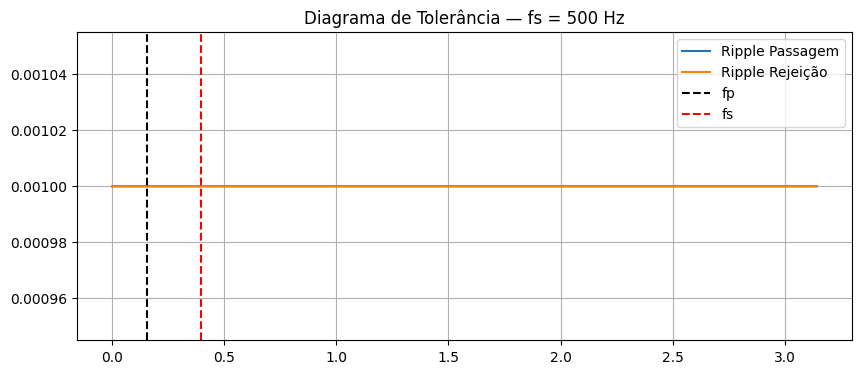

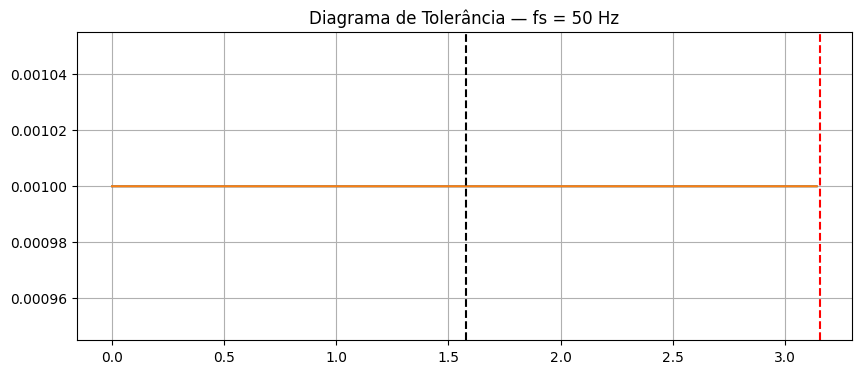

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Especificações
fs1 = 500
fs2 = 50

# Banda útil real
fp = 4     # Hz
fsb = 10   # Hz para fs=500
fsb2 = 8   # Hz para fs=50

Ap = 0.001   # ripple de passagem
As = 0.001   # ripple de rejeição

# Diagramas
w = np.linspace(0, np.pi, 2000)

plt.figure(figsize=(10,4))
plt.plot(w, np.ones_like(w)*Ap, label='Ripple Passagem')
plt.plot(w, np.ones_like(w)*As, label='Ripple Rejeição')
plt.axvline(2*np.pi*fp/fs1*np.pi, color='k', linestyle='--', label='fp')
plt.axvline(2*np.pi*fsb/fs1*np.pi, color='r', linestyle='--', label='fs')
plt.title("Diagrama de Tolerância — fs = 500 Hz")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(w, np.ones_like(w)*Ap)
plt.plot(w, np.ones_like(w)*As)
plt.axvline(2*np.pi*fp/fs2*np.pi, color='k', linestyle='--')
plt.axvline(2*np.pi*fsb2/fs2*np.pi, color='r', linestyle='--')
plt.title("Diagrama de Tolerância — fs = 50 Hz")
plt.grid()
plt.show()


Parte C: SÍNTESE DOS FILTROS FIR (Janela de Kaiser)

Projetar os filtros FIR com Kaiser

In [ ]:
from scipy.signal import kaiserord, firwin

# Filtro fs = 500 Hz
transition_bw1 = (10 - 4) / fs1
N1, beta1 = kaiserord(60, transition_bw1)

h1 = firwin(N1+1, 4/(fs1/2), window=('kaiser', beta1))

# Filtro fs = 50 Hz
transition_bw2 = (8 - 4) / fs2
N2, beta2 = kaiserord(60, transition_bw2)

h2 = firwin(N2+1, 4/(fs2/2), window=('kaiser', beta2))

print("Ordem filtro (fs=500 Hz):", N1)
print("Ordem filtro (fs=50 Hz):", N2)
print("Beta fs=500:", beta1, "  Beta fs=50:", beta2)


Ordem filtro (fs=500 Hz): 606
Ordem filtro (fs=50 Hz): 92
Beta fs=500: 5.65326   Beta fs=50: 5.65326


Parte D: APLICAÇÃO DOS FILTROS

In [ ]:
from scipy.signal import lfilter, decimate

# Dados originais
v = dados["v"].flatten()
fs = 500

# Decimação
vd = decimate(v, 10)
fsd = fs / 10

# Convolução
y_conv_500 = np.convolve(v, h1, mode='same')
y_lf_500 = lfilter(h1, 1, v)

# 50 Hz
y_conv_50 = np.convolve(vd, h2, mode='same')
y_lf_50 = lfilter(h2, 1, vd)

# Atraso = metade da ordem
delay_500 = N1 // 2
delay_50 = N2 // 2

print("Atraso fs=500 Hz:", delay_500, "amostras")
print("Atraso fs=50 Hz:", delay_50, "amostras")

Atraso fs=500 Hz: 303 amostras
Atraso fs=50 Hz: 46 amostras


Gráficos comparativos

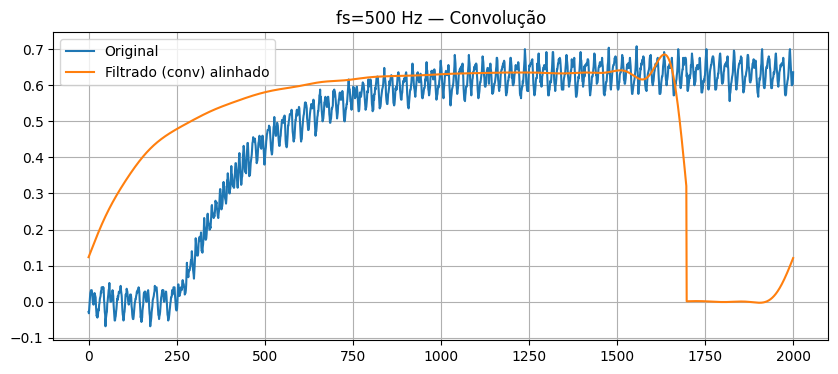

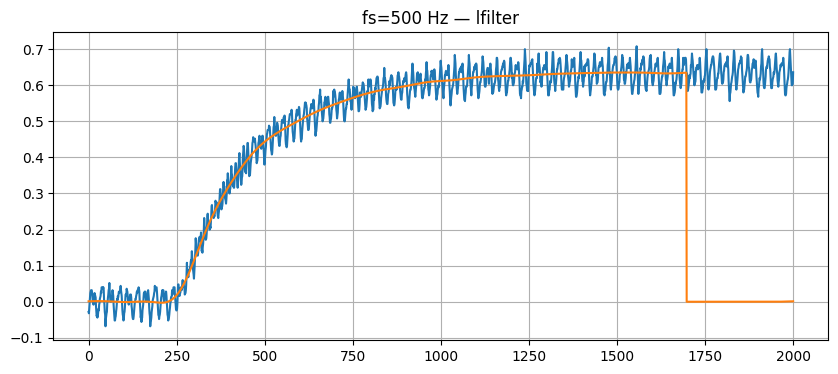

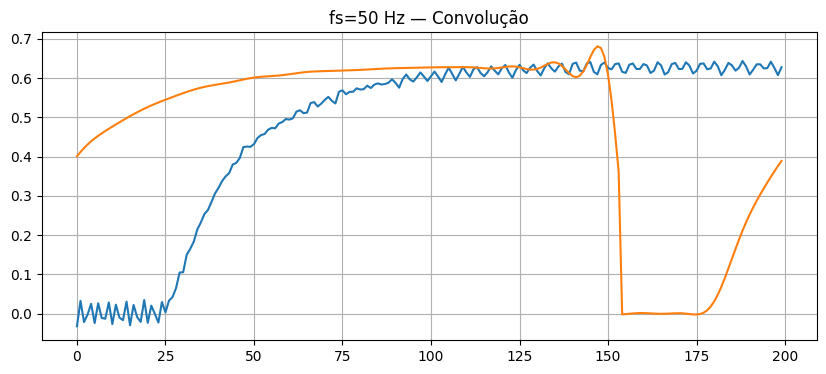

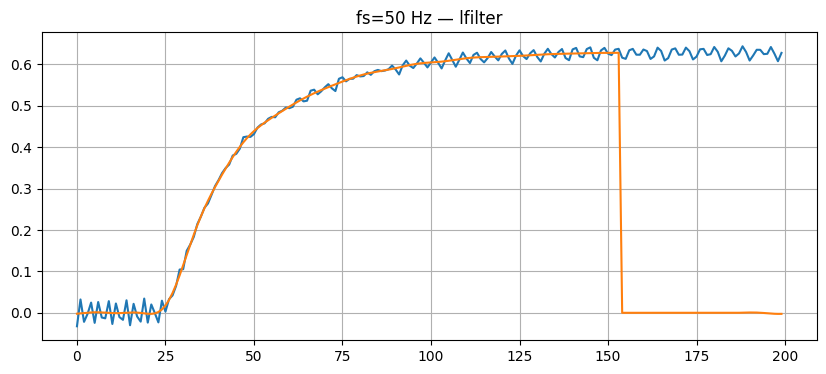

In [ ]:
# FS 500 — convolução
plt.figure(figsize=(10,4))
plt.plot(v, label="Original")
plt.plot(np.roll(y_conv_500, -delay_500), label="Filtrado (conv) alinhado")
plt.title("fs=500 Hz — Convolução")
plt.legend()
plt.grid()
plt.show()

# FS 500 — lfilter
plt.figure(figsize=(10,4))
plt.plot(v)
plt.plot(np.roll(y_lf_500, -delay_500))
plt.title("fs=500 Hz — lfilter")
plt.grid()
plt.show()

# FS 50 — convolução
plt.figure(figsize=(10,4))
plt.plot(vd)
plt.plot(np.roll(y_conv_50, -delay_50))
plt.title("fs=50 Hz — Convolução")
plt.grid()
plt.show()

# FS 50 — lfilter
plt.figure(figsize=(10,4))
plt.plot(vd)
plt.plot(np.roll(y_lf_50, -delay_50))
plt.title("fs=50 Hz — lfilter")
plt.grid()
plt.show()


Parte E: FILTRAGEM COM MÉDIA MÓVEL

Zeros da resposta do filtro de média móvel

In [ ]:
def moving_average(M):
    return np.ones(M+1)/(M+1)

def zeros_MM(M, fs):
    w = 2*np.pi*np.arange(1, M+1)/(M+1)
    f = w/(2*np.pi) * fs
    return f

print("Zeros M=7 (fs=50):", zeros_MM(7, 50))
print("Zeros M=60 (fs=500):", zeros_MM(60, 500))


Zeros M=7 (fs=50): [ 6.25 12.5  18.75 25.   31.25 37.5  43.75]
Zeros M=60 (fs=500): [  8.19672131  16.39344262  24.59016393  32.78688525  40.98360656
  49.18032787  57.37704918  65.57377049  73.7704918   81.96721311
  90.16393443  98.36065574 106.55737705 114.75409836 122.95081967
 131.14754098 139.3442623  147.54098361 155.73770492 163.93442623
 172.13114754 180.32786885 188.52459016 196.72131148 204.91803279
 213.1147541  221.31147541 229.50819672 237.70491803 245.90163934
 254.09836066 262.29508197 270.49180328 278.68852459 286.8852459
 295.08196721 303.27868852 311.47540984 319.67213115 327.86885246
 336.06557377 344.26229508 352.45901639 360.6557377  368.85245902
 377.04918033 385.24590164 393.44262295 401.63934426 409.83606557
 418.03278689 426.2295082  434.42622951 442.62295082 450.81967213
 459.01639344 467.21311475 475.40983607 483.60655738 491.80327869]


Aplicar média móvel

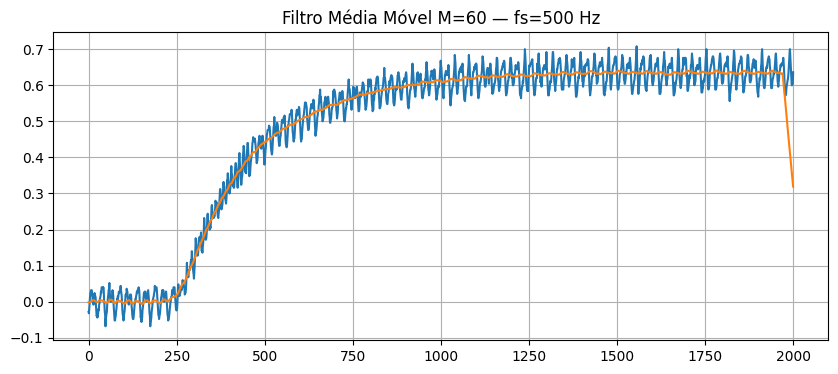

In [ ]:
# M = 7
h7 = moving_average(7)
y7_50 = np.convolve(vd, h7, mode='same')

# M = 60
h60 = moving_average(60)
y60_500 = np.convolve(v, h60, mode='same')

plt.figure(figsize=(10,4))
plt.plot(v)
plt.plot(y60_500)
plt.title("Filtro Média Móvel M=60 — fs=500 Hz")
plt.grid()
plt.show()


CONCLUSÕES:

Após a decimação, o espectro ficou muito mais limpo

Filtros mais curtos, mais simples e com menor atraso.

Filtro FIR com janela de Kaiser (fs=500 Hz)

→ Ordem muito alta (Δf pequena).
→ Atraso significativo.

Filtro FIR (fs=50 Hz)

→ Ordem muito menor.
→ Melhor relação qualidade × custo computacional.

Média móvel

M=7 (fs=50 Hz): remove bem interferências leves.

M=60 (fs=500 Hz): suaviza muito, mas distorce início do degrau.

Melhor solução final:

→ Filtro FIR com Kaiser em fs = 50 Hz
Excelente equilíbrio entre ruído, forma do sinal e custo computacional.